In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

In [2]:
df = pd.read_csv('../datasets/data.csv')

In [3]:
from dataset import clean_data

df = clean_data(df)

In [4]:
df = df['Temperature_Avg']

In [5]:
df

2017-01-01      -2
2017-01-02    -1.6
2017-01-03    -1.3
2017-01-04      -2
2017-01-05     1.2
              ... 
2022-12-27     6.7
2022-12-28     3.5
2022-12-29     1.5
2022-12-30     4.6
2022-12-31     5.9
Name: Temperature_Avg, Length: 2156, dtype: object

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [7]:
scaler.fit(np.array((-35, 45)).reshape(-1, 1))

MinMaxScaler()

In [8]:
scaled = scaler.transform(np.array(df).reshape(-1, 1))

In [9]:
scaled.shape

(2156, 1)

In [10]:
scaled

array([[0.4125 ],
       [0.4175 ],
       [0.42125],
       ...,
       [0.45625],
       [0.495  ],
       [0.51125]])

In [11]:
train = torch.tensor(scaled, dtype=torch.float32)

In [12]:
train.shape

torch.Size([2156, 1])

In [13]:
from train import build_set, train_model

In [14]:
x_train, y_train = build_set(train, 0, 5)

In [15]:
x_train.shape

torch.Size([2151, 5, 1])

In [16]:
from models import MyLSTM

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MyLSTM(input_size=train.shape[1], hidden_size=5, num_layers=2, dropout=0.4).to(device)

In [18]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
train_loss, valid_loss = train_model(model=model, train_valid=(x_train, y_train, x_train[:3], y_train[:3]), criterion=criterion, optimizer=optimizer, epochs=150)

Epoch:   0 Sample:  300 Train Loss: 0.00060474 Avg Valid Loss: 0.03952289
Epoch:   0 Sample:  600 Train Loss: 0.15942629 Avg Valid Loss: 0.08507864
Epoch:   0 Sample:  900 Train Loss: 0.06279957 Avg Valid Loss: 0.08878397
Epoch:   0 Sample: 1200 Train Loss: 0.00897304 Avg Valid Loss: 0.05657195
Epoch:   0 Sample: 1500 Train Loss: 0.00551368 Avg Valid Loss: 0.01657457
Epoch:   0 Sample: 1800 Train Loss: 0.00186203 Avg Valid Loss: 0.02916295
Epoch:   0 Sample: 2100 Train Loss: 0.00417871 Avg Valid Loss: 0.07145287
Epoch:   1 Sample:  300 Train Loss: 0.00819549 Avg Valid Loss: 0.07228077
Epoch:   1 Sample:  600 Train Loss: 0.00476082 Avg Valid Loss: 0.13413798
Epoch:   1 Sample:  900 Train Loss: 0.00097919 Avg Valid Loss: 0.11825096
Epoch:   1 Sample: 1200 Train Loss: 0.01392138 Avg Valid Loss: 0.05518160
Epoch:   1 Sample: 1500 Train Loss: 0.00046236 Avg Valid Loss: 0.02482708
Epoch:   1 Sample: 1800 Train Loss: 0.00106656 Avg Valid Loss: 0.03942841
Epoch:   1 Sample: 2100 Train Loss: 0.

In [21]:
import os

model_path = '../models/lstm1'
os.makedirs(model_path)


torch.save(model.state_dict(), os.path.join(model_path, 'params.pt'))

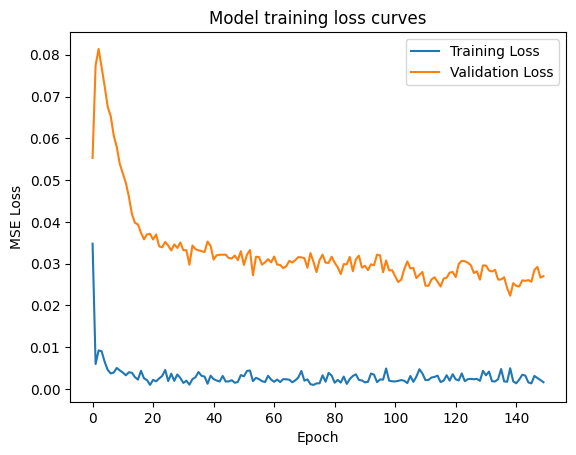

In [22]:
from train import plot_loss_curves

plot_loss_curves(train_loss, valid_loss, model_path)

In [50]:
start = x_train[-10]

In [51]:
start

tensor([[0.5350],
        [0.4712],
        [0.4162],
        [0.4050],
        [0.4000]])

In [52]:
y_train[-10:]

tensor([[0.4038],
        [0.4350],
        [0.4675],
        [0.5063],
        [0.4850],
        [0.5213],
        [0.4812],
        [0.4563],
        [0.4950],
        [0.5113]])

In [53]:
model.eval()

MyLSTM(
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=5, out_features=1, bias=True)
  (lstm): LSTM(1, 5, num_layers=2, dropout=0.4)
)

In [94]:
start = start.to(device)
pred_temps = []
hidden = model.initialize_hidden(device)

steps = 10
for i in range(steps):
    if type(hidden) == tuple:
        hidden = tuple([state.data for state in hidden])
    else:
        hidden = hidden.data

    out, hidden = model(start, hidden)
    pred_temp = float(scaler.inverse_transform(np.array(out.item()).reshape(-1,1)))
    pred_temps.append(pred_temp)
    print(out)

    torch.cat((start.flatten(), out), dim=0)[1:]



tensor([0.4676], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.4710], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.4744], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.4763], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.4772], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.4775], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.4773], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.4769], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.4764], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.4759], device='cuda:0', grad_fn=<SelectBackward0>)


In [28]:
out

tensor([0.4826], device='cuda:0', grad_fn=<SelectBackward0>)

In [36]:
pred_temp = float(scaler.inverse_transform(np.array(out.item()).reshape(-1,1)))
pred_temps.append(pred_temp)

3.605225086212158

In [37]:
start

tensor([[0.4850],
        [0.5213],
        [0.4812],
        [0.4563],
        [0.4950]], device='cuda:0')

In [38]:
out

tensor([0.4826], device='cuda:0', grad_fn=<SelectBackward0>)

In [49]:
torch.cat((start.flatten(), out), dim=0)[1:]

tensor([0.5213, 0.4812, 0.4563, 0.4950, 0.4826], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [47]:
start.flatten()

tensor([0.4850, 0.5213, 0.4812, 0.4563, 0.4950], device='cuda:0')

In [83]:
pred_temps

[0.9875750541687012,
 1.0566425323486328,
 2.1982979774475098,
 3.5837721824645996,
 6.159839630126953,
 4.392023086547852,
 7.168478965759277,
 3.9879512786865234,
 2.674417495727539,
 4.536833763122559]

In [89]:
np.array(df[-10:], dtype=np.float32)

array([-2.7, -0.2,  2.4,  5.5,  3.8,  6.7,  3.5,  1.5,  4.6,  5.9],
      dtype=float32)

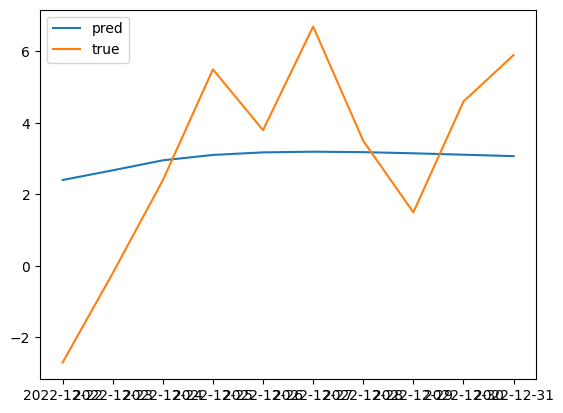

In [95]:
import matplotlib.pyplot as plt

index= df[-10:].index

# plt.plot(pred_temps)
plt.figure()
plt.plot(index, pred_temps, label='pred')
plt.plot(index, np.array(df[-10:], dtype=np.float32), label='true')
plt.legend()

In [82]:
df[-10:]

2022-12-22    -2.7
2022-12-23    -0.2
2022-12-24     2.4
2022-12-25     5.5
2022-12-26     3.8
2022-12-27     6.7
2022-12-28     3.5
2022-12-29     1.5
2022-12-30     4.6
2022-12-31     5.9
Name: Temperature_Avg, dtype: object